# Import Libraries

In [23]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

import xgboost

import pickle as pkl

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [25]:
## Extracting list of chemical elements
def elem_list(df):
    str_elem = []
    
    for col in list(df.columns):
        if col not in ['gid', 
                       'objectid', 
                       'sampleno', 
                       'longitude', 
                       'latitude', 
                       'toposheet']:
            str_elem.append(col)

    return str_elem

## Outlier handling
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## RFECV for classification
def rfecv_cls(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=StratifiedKFold(cv), 
                  scoring='accuracy')
    rfecv.fit(X, target)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    # pca_df = pca.transform(scaled_df)

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    # mse = mean_squared_error(y, y_pred)
    medae = median_absolute_error(y, y_pred)
    # rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r_squared = r2_score(y, y_pred)

    print(f'{title}')
    print(f'Median Absolute Error: {np.round(medae, 2)}')
    # print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    print(f'R-squared Error: {np.round(r_squared, 2)}')

## Plotting Learning curves
def plot_learing_curve(model, X, y, cv, model_title):

    train_sizes = [30, 50, 70, 100, 128]

    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=cv, 
                                                                  scoring='neg_mean_absolute_error', 
                                                                  shuffle=True)

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    #plt.style.use('seaborn')
    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, 
             train_scores_mean, 
             label = 'Training error')
    plt.plot(train_sizes, 
             validation_scores_mean, 
             label = 'Validation error')
    plt.ylabel('Mean MAE', 
               fontsize = 14)
    plt.xlabel('Training set size', 
               fontsize = 14)
    plt.title(f'Learning curves for a {model_title} model', 
              fontsize = 18, 
              y = 1.03)
    plt.legend()
    # plt.ylim(0,40)

# Load Data

### Train Data

In [26]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [27]:
str_sed_data = pd.read_csv(data_path + '/Ramagiri dataset/stream_sediments_57F11.csv')

In [28]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,u,pt,pd,toposheet,in_,f,te,tl,hg,cd
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,3.016905,0,0,57F11,0,0,0,0,8.0,50
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,3.378550,0,0,57F11,0,0,0,0,9.0,50
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,3.509000,0,0,57F11,0,0,0,0,2.5,50
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,4.241000,0,0,57F11,0,0,0,0,19.0,50
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,4.218000,0,0,57F11,0,0,0,0,19.0,50


### Test Data

In [142]:
test_data = pd.read_csv(data_path + '/Ramagiri dataset//gcm_CR_57f11.csv')

In [13]:
test_data.head()

,gid,objectid_1,ssampleno,type,longitude,latitude,SiO2,Al2O3,Fe2O3,TiO2,...,Pt,Pd,Soi_No.,F,In,Te,Tl,Cd,Hg,View on Map
0,2277,247676,57F11/A1/R/12,Regolith,77.5417,14.4583,46.35,21.43,12.24,1.15,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
1,2278,247677,57F11/A2/R/12,Regolith,77.5417,14.3750,43.29,24.93,15.26,1.06,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
2,2279,247678,57F11/A3/R/12,Regolith,77.5417,14.2917,57.83,17.57,5.42,0.79,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
3,2280,247679,57F11/A4/R/12,Regolith,77.6250,14.4583,48.06,20.14,10.82,0.56,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN
4,2281,247680,57F11/A5/R/12,Regolith,77.6250,14.3750,61.78,16.94,5.75,0.71,...,0,0,57F11,0,0,0,0,NaN,NaN,NaN


# EDA

In [29]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: ['pt', 'pd', 'in_', 'f', 'te', 'tl']


In [30]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [31]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,0.359742,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,57F11,8.0,50
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,0.419132,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,57F11,9.0,50
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,0.329000,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,57F11,2.5,50
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,0.306000,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,57F11,19.0,50
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,0.334000,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,57F11,19.0,50


In [32]:
str_elem = elem_list(str_sed_data)
len(str_elem)

59

In [33]:
zero_count_features = (str_sed_data[str_elem] == 0).sum()
df = zero_count_features[zero_count_features > 1]
mis_val_col = df.index.to_list()
mis_val_col

['li', 'cs', 'as_', 'sb', 'bi', 'se']

All the missing values in the above elements are in the same samples. Hence we drop them.

In [34]:
rows = (str_sed_data[mis_val_col] == 0).any(axis=1)
str_sed_data = str_sed_data[~rows]
str_sed_data.shape

(200, 65)

In [35]:
str_sed_data.tail()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
198,4774,4774,57F07/028/SS/12,77.5,14.277027,67.670,14.14,3.42,0.05,1.29,...,0.418,2.669,0.435,12.326000,1.009,2.5,3.255,57F07,2.5,50
199,4788,4788,57F07/042/SS/12,77.5,14.295045,66.980,12.88,4.86,0.06,1.28,...,0.363,2.251,0.352,11.946000,1.663,2.5,4.438,57F07,5.0,50
200,4970,4970,57F07/014/SS/12,77.5,14.259009,66.624,15.01,3.29,0.07,0.98,...,0.516,3.423,0.540,9.460000,1.612,2.5,3.479,57F07,2.5,50
201,5059,5059,57F07/056/SS/12,77.5,14.313063,62.050,14.09,5.30,0.09,1.72,...,0.562,3.336,0.546,16.966999,1.762,2.5,5.554,57F07,8.0,50
202,5073,5073,57F07/070/SS/12,77.5,14.331081,64.030,12.09,2.74,0.05,2.66,...,0.453,2.905,0.509,25.667000,0.895,2.5,4.153,57F07,2.5,50


In [36]:
str_sed_data.reset_index(inplace=True, drop='index')

In [37]:
str_sed_data.tail()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,tm,yb,lu,hf,ta,w,u,toposheet,hg,cd
195,4774,4774,57F07/028/SS/12,77.5,14.277027,67.670,14.14,3.42,0.05,1.29,...,0.418,2.669,0.435,12.326000,1.009,2.5,3.255,57F07,2.5,50
196,4788,4788,57F07/042/SS/12,77.5,14.295045,66.980,12.88,4.86,0.06,1.28,...,0.363,2.251,0.352,11.946000,1.663,2.5,4.438,57F07,5.0,50
197,4970,4970,57F07/014/SS/12,77.5,14.259009,66.624,15.01,3.29,0.07,0.98,...,0.516,3.423,0.540,9.460000,1.612,2.5,3.479,57F07,2.5,50
198,5059,5059,57F07/056/SS/12,77.5,14.313063,62.050,14.09,5.30,0.09,1.72,...,0.562,3.336,0.546,16.966999,1.762,2.5,5.554,57F07,8.0,50
199,5073,5073,57F07/070/SS/12,77.5,14.331081,64.030,12.09,2.74,0.05,2.66,...,0.453,2.905,0.509,25.667000,0.895,2.5,4.153,57F07,2.5,50


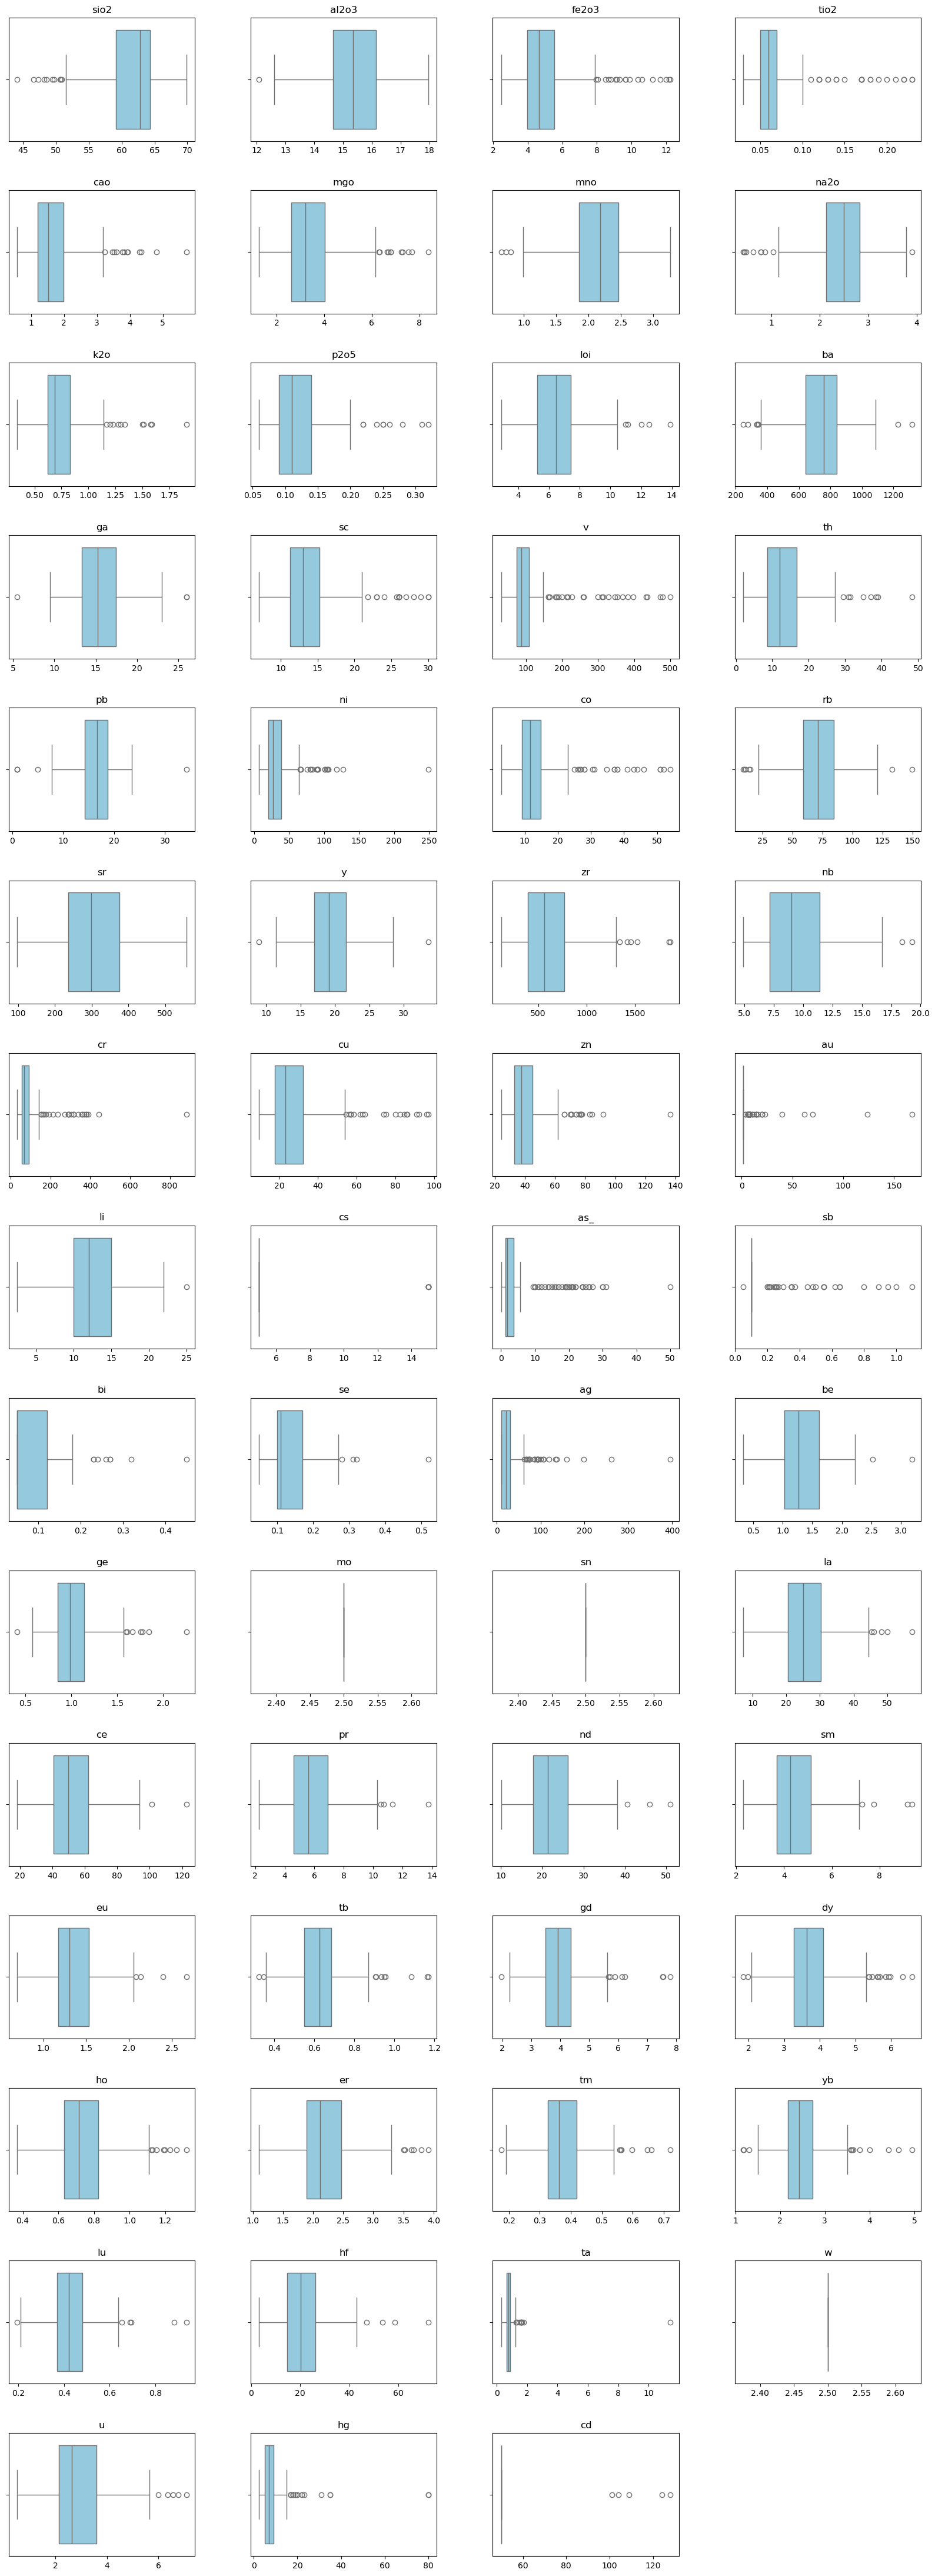

In [131]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_sed_data[str_elem].columns, axes.flatten())):
    sns.boxplot(x=str_sed_data[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

- Removing elements which have same value for each sample.

In [38]:
str_sed_data.drop(['cs', 'sb', 'mo', 'sn', 'w', 'cd'], axis=1, inplace=True)

- Handling outliers for 'Gold' feature using KNN 

In [17]:
str_sed_data['au'].value_counts()

au
1.5      167
8.0        7
6.0        7
20.0       3
14.0       3
10.0       2
4.0        2
16.0       1
124.0      1
168.0      1
70.0       1
40.0       1
7.0        1
12.0       1
62.0       1
23.0       1
Name: count, dtype: int64

In [53]:
au_outl = str_sed_data[str_sed_data['au'] >= 20]

In [54]:
# Assuming you define 'neighbors' based on some logical geographical proximity
nbrs = NearestNeighbors(n_neighbors=5, 
                        algorithm='ball_tree').fit(str_sed_data[['latitude', 
                                                                 'longitude']])
distances, indices = nbrs.kneighbors(str_sed_data[['latitude', 
                                                   'longitude']])

for index, row in au_outl.iterrows():
    # Calculate the mean of the nearest neighbors excluding the outlier itself
    neighbor_indices = indices[index][1:]  # exclude the first index since it's the point itself
    mean_au = str_sed_data.iloc[neighbor_indices]['au'].mean()
    str_sed_data.at[index, 'au'] = np.round(mean_au, 2)

- Handling outliers for 'Arsenic' feature using highest count capping

In [56]:
str_sed_data[str_sed_data['as_'] >= 19]['as_'].value_counts()

as_
19.00    6
21.00    5
24.00    4
26.00    3
30.00    2
20.00    2
22.00    2
27.00    1
21.33    1
25.00    1
31.00    1
50.00    1
19.50    1
Name: count, dtype: int64

In [58]:
upr_bnd = 19.00
str_sed_data['as_'] = str_sed_data['as_'].apply(lambda x: upr_bnd if x > upr_bnd else x)

- Handling outliers using winsorize method

In [39]:
str_elem = elem_list(str_sed_data)

In [40]:
elem_outl_df = handle_outl(str_sed_data[str_elem])

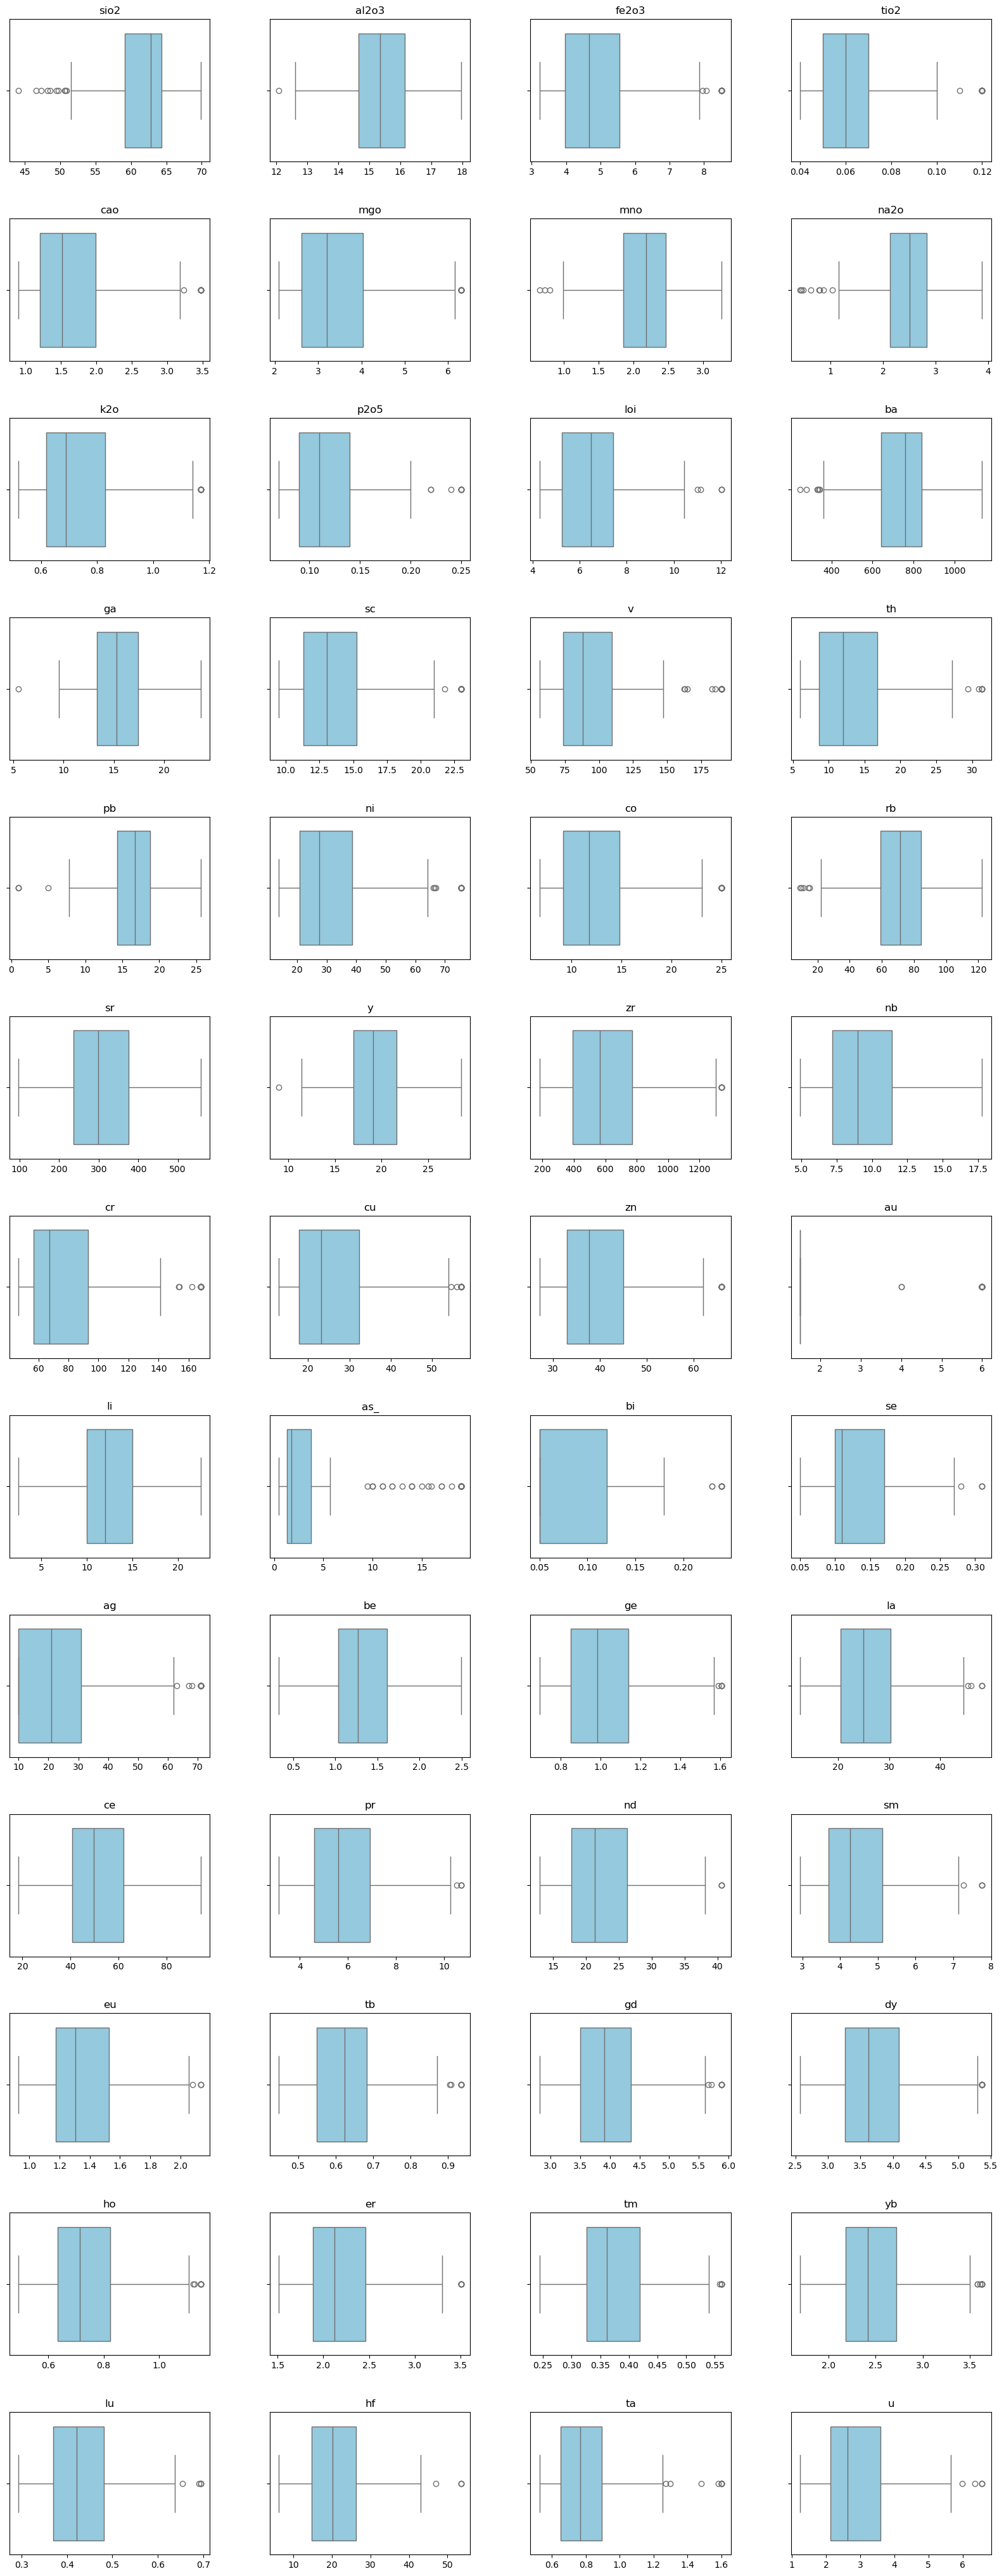

In [21]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

In [41]:
for elem in list(elem_outl_df[str_elem].columns):
    Q1 = elem_outl_df[elem].quantile(0.25)
    Q3 = elem_outl_df[elem].quantile(0.75)
    IQR = Q3 - Q1
    lwr_bnd = Q1 - (1.5 * IQR)
    upr_bnd = Q3 + (1.5 * IQR)

    elem_outl_df[elem] = elem_outl_df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)

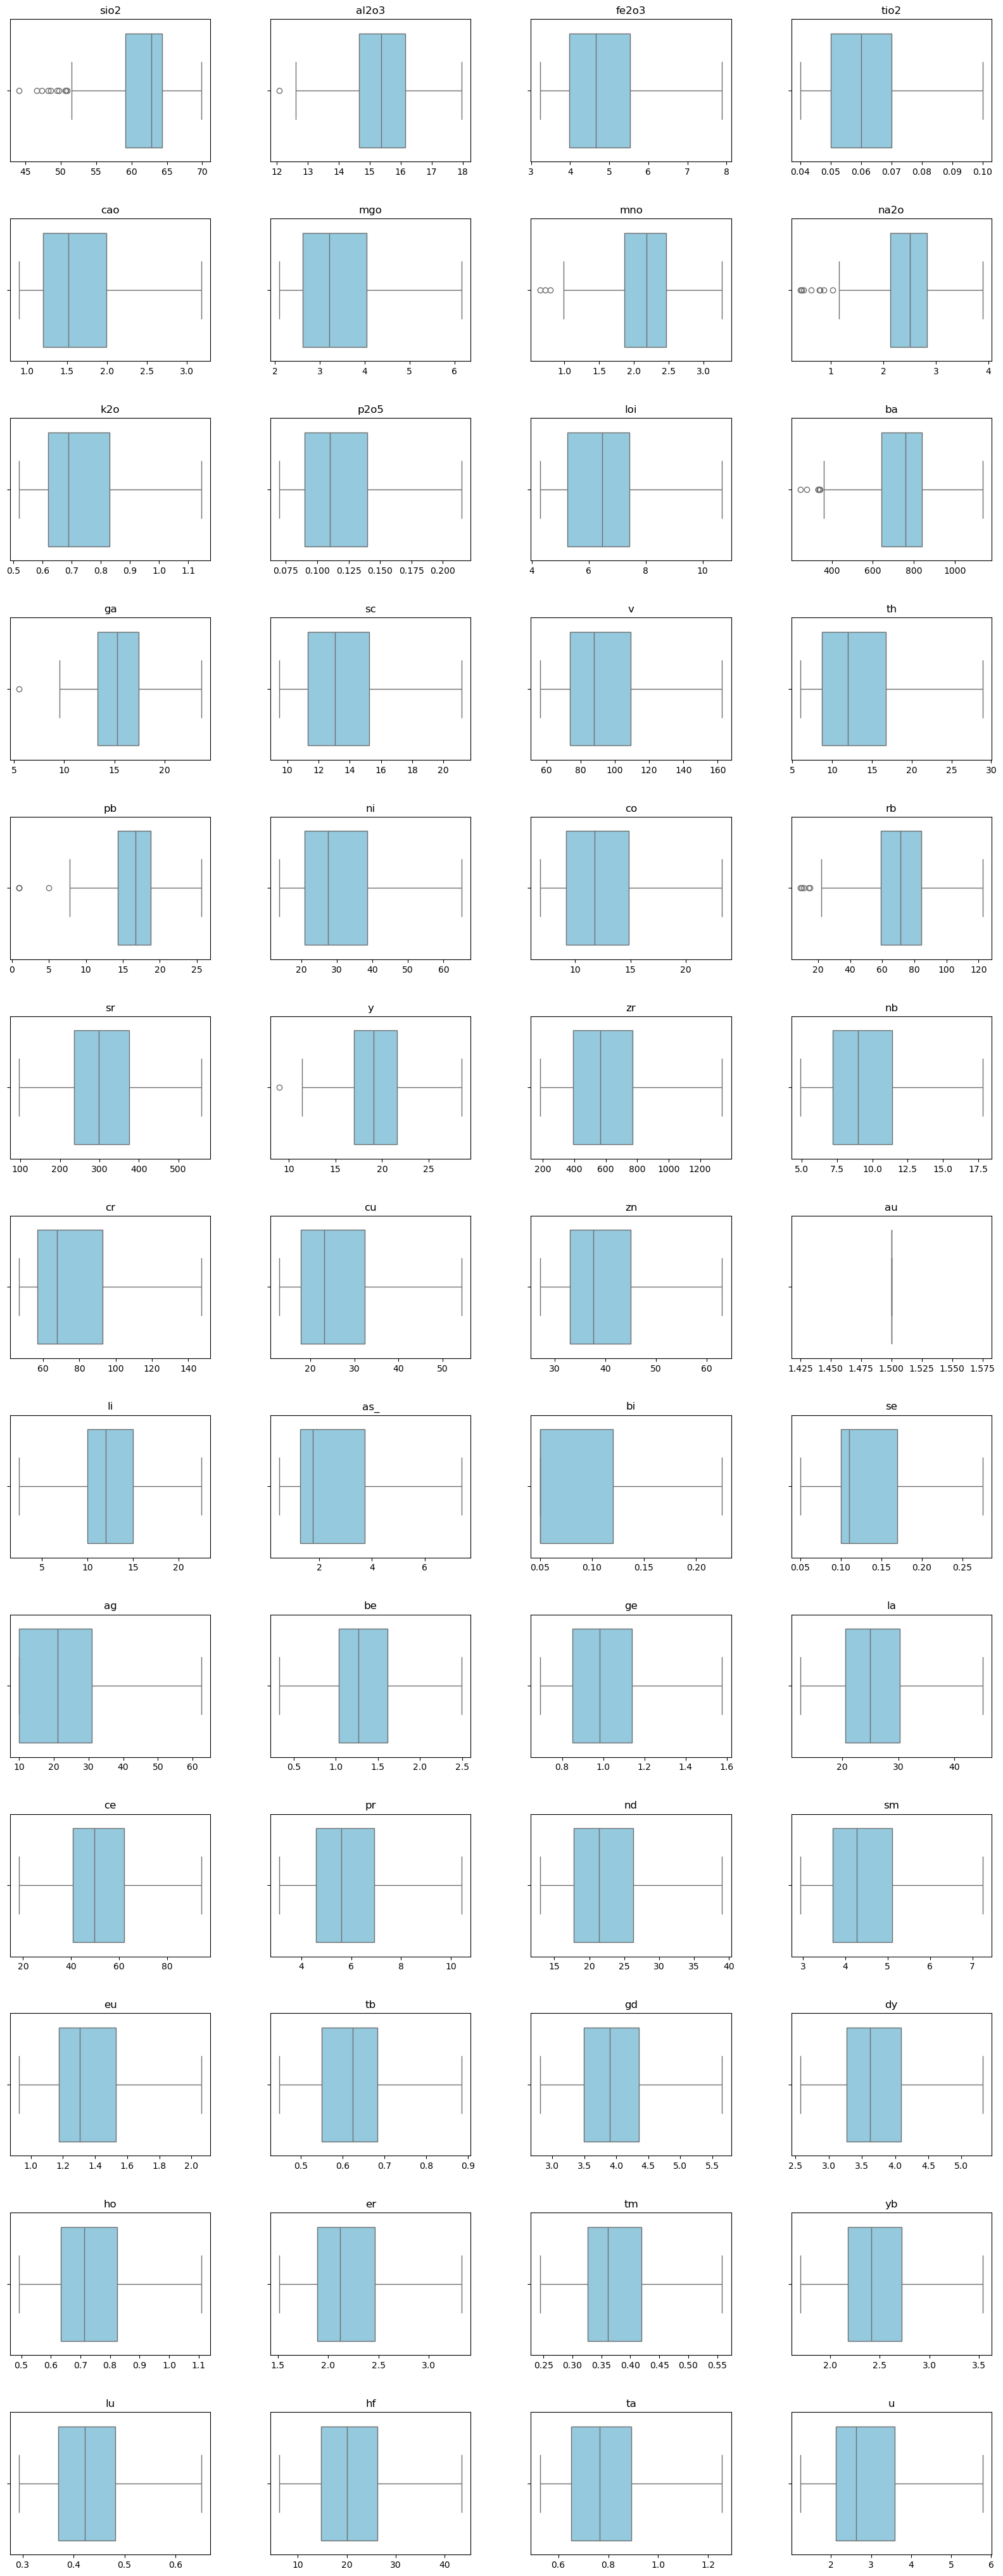

In [42]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Prediction

## Train test split

In [67]:
train_df = elem_outl_df[str_elem]
train_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,dy,ho,er,tm,yb,lu,hf,ta,u,hg
0,61.921,14.606,4.51,0.05,2.28,3.24,1.52,2.46,0.61,0.13,...,3.725699,0.730795,2.139445,0.359742,2.290226,0.413697,26.874492,0.677483,3.016905,8.0
1,62.077,13.750,4.22,0.05,2.43,4.14,1.52,2.55,0.64,0.12,...,4.140085,0.783322,2.405519,0.419132,2.891123,0.500104,37.079419,0.774466,3.378550,9.0
2,68.645,13.410,3.23,0.05,1.32,3.19,2.89,3.08,0.75,0.08,...,3.404000,0.651000,1.919000,0.329000,2.323000,0.423000,23.652000,0.715000,3.509000,2.5
3,64.302,14.010,4.08,0.05,1.84,3.24,2.12,2.83,0.75,0.16,...,3.475000,0.655000,2.042000,0.334000,2.322000,0.431000,26.705000,0.832000,4.218000,15.0
4,64.346,14.940,5.25,0.07,1.38,2.59,2.31,2.95,1.05,0.17,...,3.457000,0.650000,1.978000,0.320000,2.311000,0.403000,23.323999,0.739000,3.882000,12.0


In [68]:
target = train_df['as_']
train_df.drop(['as_'], axis=1, inplace=True)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle=True)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

In [71]:
sc = RobustScaler()

norm_data = sc.fit_transform(X_train)

X_train_norm = pd.DataFrame(norm_data, 
                            index=X_train.index, 
                            columns=X_train.columns)

## Estimator: Random Forest

In [47]:
rf = RandomForestRegressor()
rfecv_rf = rfecv(rf, X_train_norm, y_train, 1, 5)

In [48]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 5


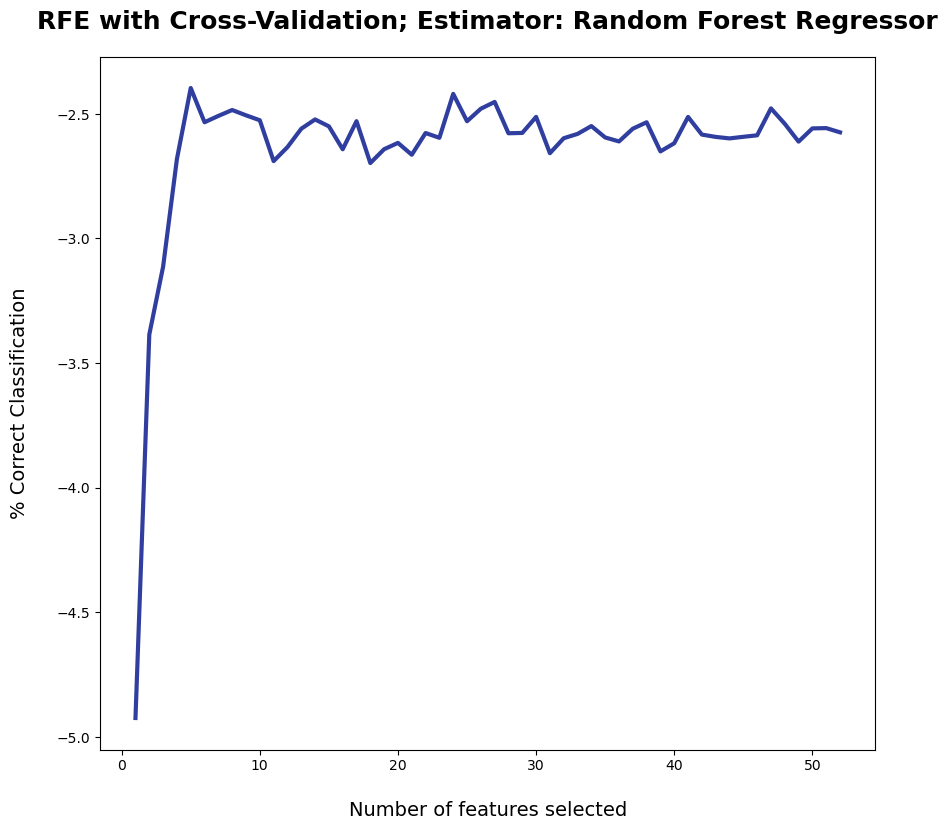

In [49]:
plot_pcc(rfecv_rf, 'RFE with Cross-Validation; Estimator: Random Forest Regressor')

In [50]:
X_rf = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_rf.support_ == False)[0]], axis=1)

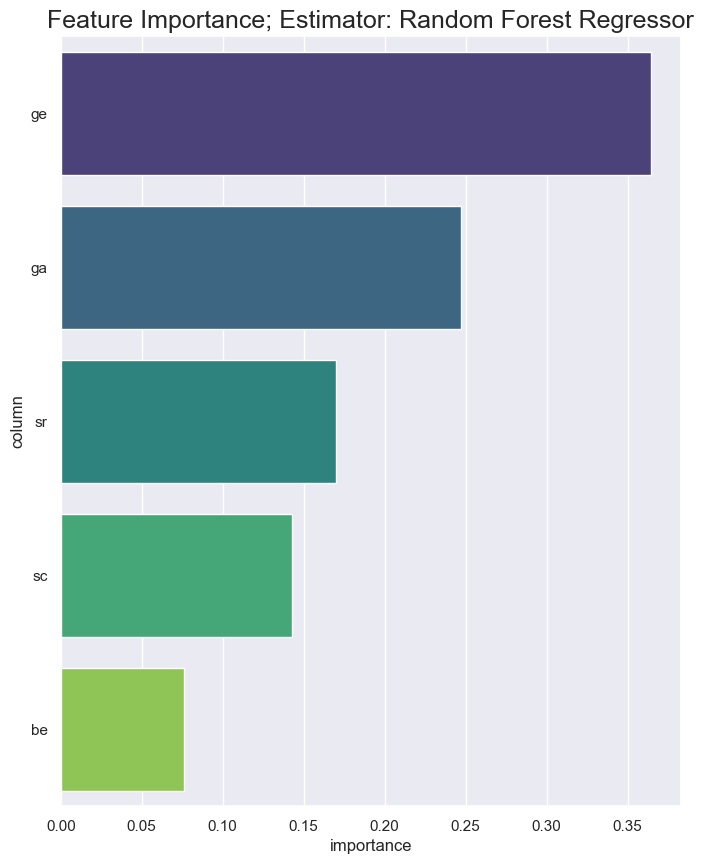

In [51]:
feature_importance(rfecv_rf, X_rf, 'Feature Importance; Estimator: Random Forest Regressor')

In [ ]:
# X_rf = X_rf[['sio2', 'zn', 'co', 'k2o', 'rb', 'mno', 'ni']]
X_rf = X_rf[['fe2o3', 'k2o', 'v', 'zn', 'tio2', 'sio2', 'co', 'ni', 'rb', 'cr', 'th', 'zr']]

## Random Forest

In [72]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider at every split
    'max_depth': [10, 20, 30],    # Maximum number of levels in each tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum number of samples required at each leaf node
}

rf = RandomForestRegressor()

grid_search_rfr_rf = GridSearchCV(rf, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_absolute_error',
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_rfr_rf.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search_rfr_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Run the models on validation data 

In [73]:
y_pred_val = pred_val(X_val, list(X_train_norm.columns), sc, grid_search_rfr_rf)

In [74]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Median Absolute Error: 0.96
Mean Absolute Error: 1.09
R-squared Error: 0.75


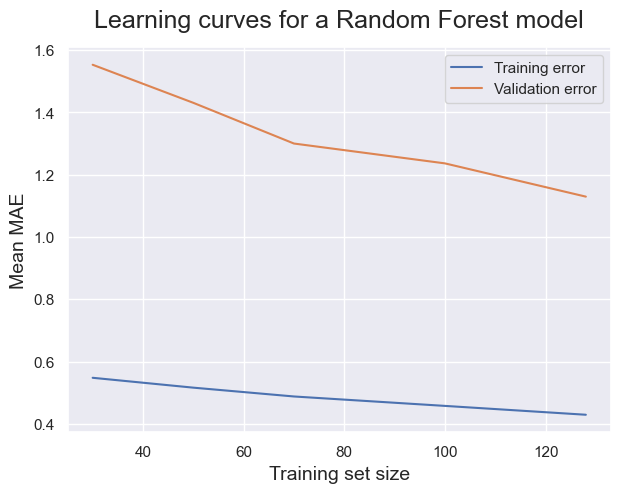

In [78]:
plot_learing_curve(RandomForestRegressor(max_depth=20, 
                                         max_features='sqrt', 
                                         min_samples_leaf=1, 
                                         min_samples_split=2, 
                                         n_estimators=200), 
                   X_train_norm, y_train, 5, 'Random Forest')

In [110]:
y_pred = pred_val(X_test, list(X_train_norm.columns), sc, grid_search_rfr_rf)

In [111]:
eval_model(y_test, y_pred, 'Test set')

Test set
Median Absolute Error: 0.55
Mean Absolute Error: 1.04
R-squared Error: -0.22


In [112]:
plot_vals = pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

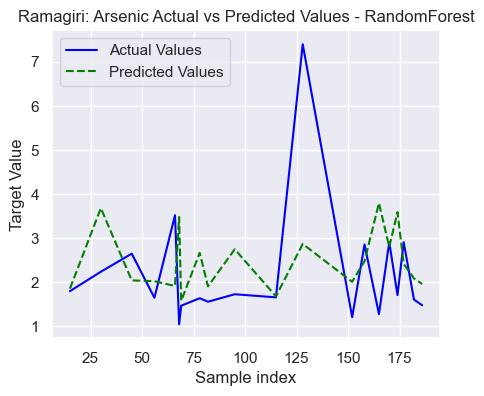

In [113]:
plt.figure(figsize=(5, 4))
plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
plt.title('Ramagiri: Arsenic Actual vs Predicted Values - RandomForest')
plt.xlabel('Sample index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [75]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0, 0.1, 0.5, 1],       
    'reg_lambda': [0.5, 1, 1.5, 2],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search_xgb_rf = GridSearchCV(xgb, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_absolute_error', 
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_xgb_rf.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search_xgb_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0.5}


### Run the models on validation data

In [76]:
y_pred_val = pred_val(X_val, list(X_train_norm.columns), sc, grid_search_xgb_rf)

In [77]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Median Absolute Error: 0.64
Mean Absolute Error: 0.96
R-squared Error: 0.78


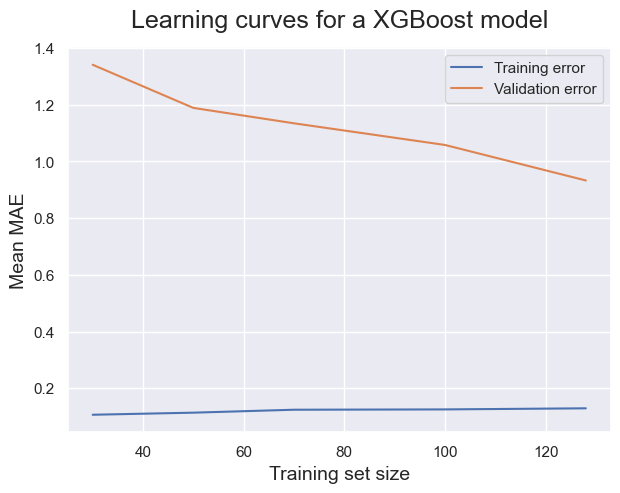

In [79]:
plot_learing_curve(xgboost.XGBRegressor(colsample_bytree=0.5, 
                                        gamma=0.1, 
                                        learning_rate=0.1, 
                                        max_depth=3, 
                                        n_estimators=100, 
                                        objective='reg:squarederror', 
                                        reg_alpha=0, 
                                        reg_lambda=0.5), 
                   X_train_norm, y_train, 5, 'XGBoost')

In [106]:
y_pred = pred_val(X_test, list(X_train_norm.columns), sc, grid_search_xgb_rf)

In [107]:
plot_vals = pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

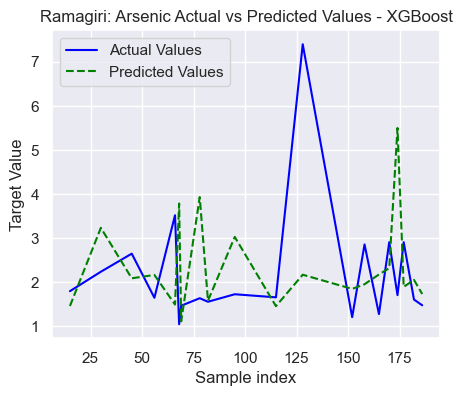

In [109]:
plt.figure(figsize=(5, 4))
plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
plt.title('Ramagiri: Arsenic Actual vs Predicted Values - XGBoost')
plt.xlabel('Sample index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()